In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

import matplotlib as mpl
#from datetime import datetime
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

from scipy import signal
import scipy.interpolate
from scipy import stats


mpl.rcParams.update(mpl.rcParamsDefault)
#plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams.update({
#     "text.usetex": True
# })

#mpl.rcParams['text.usetex'] = True

# plt.rcParams["font.family"] = "Helvetica"
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

In [2]:
def read_ens_cdf_var(cr, var_dev, no_members):
    
    input_file = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\Ensemble_Members\\vardev_{var_dev}_{no_members}\\carrot_{cr}_set.nc'

    # Read the NetCDF file into an xarray Dataset
    loaded_ds = xr.open_dataset(input_file)

    # Initialize an empty list to store DataFrames
    df_list = []

    # Loop through ensemble members xarray dimension, convert each member to pandas dataframe, append to list
    for i in range(no_members):
        df_list.append(loaded_ds.sel(ensemble_members = i).to_dataframe())

    return df_list

In [3]:
def perturb_longitude(shift_amount, ensemble_member):
    
    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype(int) // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()
    
    return df_shifted[~(df_shifted.index).duplicated()].copy()

In [10]:
def interpolate_and_resample(omni_data, forecast_series):
    # This function runs an interpolation algorithm on forecast output and outputs a resamples forecast series on the omni data timestep

    Int = scipy.interpolate.CubicSpline(forecast_series.index, forecast_series['vsw'])
    
    data_time_axis = omni_data.index

    interpolated_forecast_output = Int(data_time_axis)

    return interpolated_forecast_output

def gen_ranked_ensemble(ensemble_members, omni_data): 

    vsw_list = [] # Initialise list for forecast output

    # Prepare data for rank comparison
    #omni_chunk = omni_data.loc[ensemble_members[0]['datetime'].iloc[0]:ensemble_members[0]['datetime'].iloc[-1]]
    omni_chunk = omni_data.loc[pd.to_datetime(ensemble_members[0].index[0]):pd.to_datetime(ensemble_members[0].index[-1])]
 
    omni_chunk = omni_chunk.dropna(subset = ['V']) # Remove rows with NaN values

    # Interpolate and resample forecast output onto OMNI data time ste[]
    for vsw in ensemble_members:
        vsw_int = interpolate_and_resample(omni_chunk, vsw)
        vsw_list.append(vsw_int)

    # Compare ensemble member output arrays to omni data 
    vsw_arr = np.array(vsw_list)
    print(np.shape(vsw_arr))
    ranked_forecast_boolean = np.array([vsw < omni_chunk['V'] for vsw in vsw_arr])
    print(np.shape(ranked_forecast_boolean))
    summed_ranks = np.sum(ranked_forecast_boolean, axis = 0)
    print(np.shape(summed_ranks))

    return summed_ranks

In [5]:
def perturb_ensemble_set_by_longitude(ensemble_members, ensemble_size, long_dev):
    
    carrington_rotation = 27.2753 * u.day

    lp_ensemble_members = [] # Initialise list of lognitudinally perturbed (lp) ensemble members

    long_pert = rng.normal(loc = 0, scale = long_dev, size = ensemble_size)
    long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day 

    for i in range(ensemble_size):
        
        shifted_df = perturb_longitude(shift_amount=long_pert_dt[i], ensemble_member=(ensemble_members[i].copy().set_index('datetime')))
        lp_ensemble_members.append(shifted_df.copy())
    
    return lp_ensemble_members

def calculate_rank_chi_square(ensemble_size, ranked_forecasts):
        
    ensemble_hist = np.histogram(ranked_forecasts, bins = ensemble_size)[0]

    chi_sq_alt = 0 
    
    for i in range(ensemble_size):
        
        chi_sq_alt += (ensemble_hist[i]/np.sum(ensemble_hist) - 1/(ensemble_size+1))**2

    chi_sq_alt = chi_sq_alt*np.sum(ensemble_hist)*(ensemble_size+1)

    return chi_sq_alt


In [6]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\OMNI\\Processed_omni\\'

# load the data back in
omni_1hour = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_1hour = omni_1hour.set_index('datetime')


In [7]:
rng = np.random.default_rng()
cr = 2242
var_dev = 20
no_members = 100
long_pert_var = 0 # Degrees
carrington_rotation = 27.2753 * u.day


ensemble_members = read_ens_cdf_var(cr=cr, var_dev=var_dev, no_members=no_members)
lp_ensemble_members = [] # Initialise list of lognitudinally perturbed (lp) ensemble members

for df in ensemble_members:

    long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
    long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
    shifted_df = perturb_longitude(shift_amount=1*u.day, ensemble_member=(df.set_index('datetime')))
    lp_ensemble_members.append(shifted_df)

(100, 637)
(100, 637)
(637,)
(637,)
4219.4387521954695


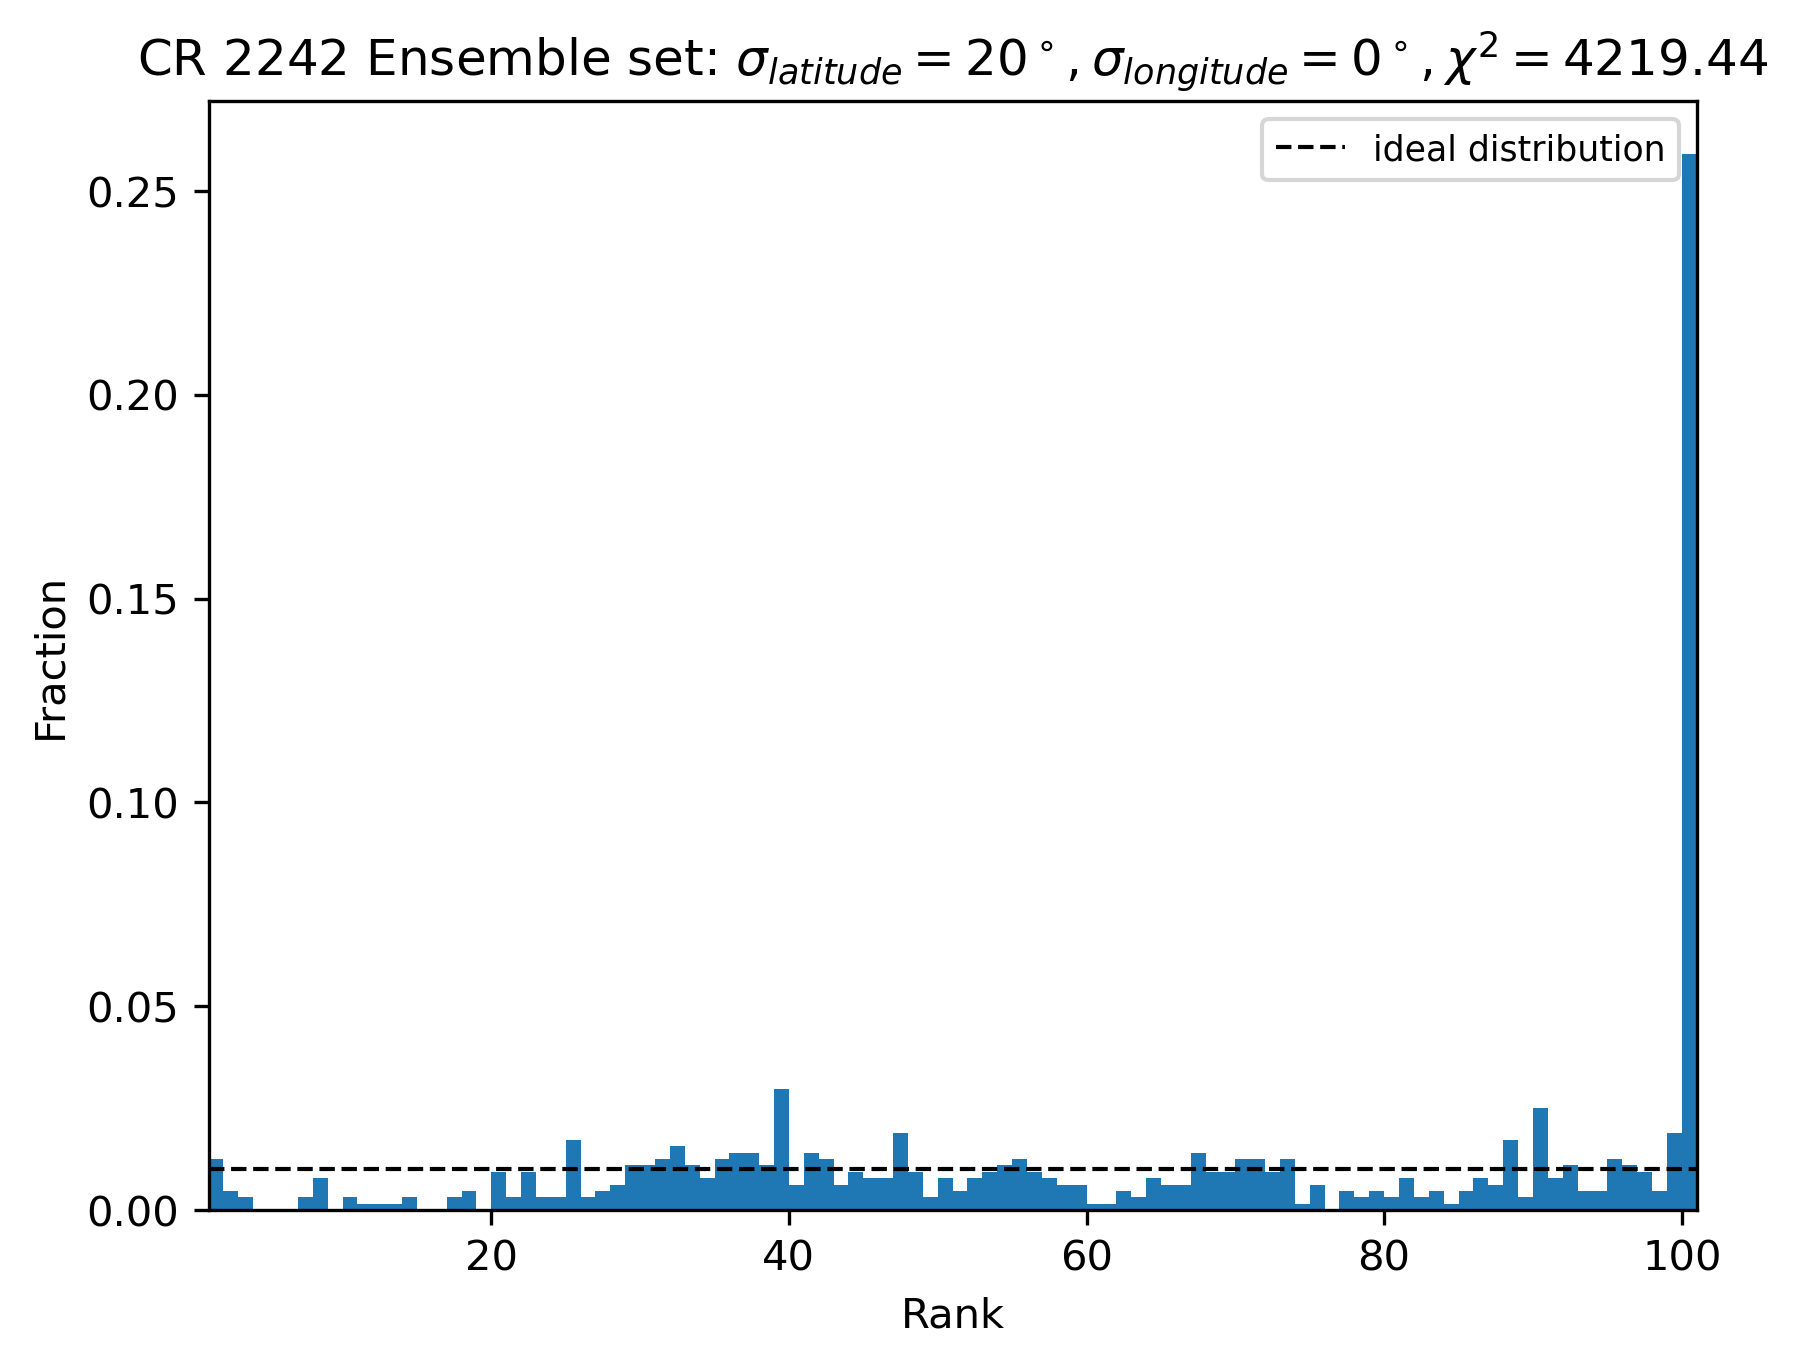

In [11]:
ranked_forecasts = gen_ranked_ensemble(lp_ensemble_members, omni_1hour)
print(np.shape(ranked_forecasts))
chi_sq = calculate_rank_chi_square(100, ranked_forecasts)
print(calculate_rank_chi_square(100, ranked_forecasts))

#ranked_forecast_arr = np.concatenate(ranked_forecasts) + 1

plt.figure(dpi = 300)
plt.hist(ranked_forecasts + 1, density = 'True', bins = no_members)
plt.axhline(1/no_members, linestyle = '--', color = 'black', lw = 1, label = 'ideal distribution')
plt.xlabel('Rank')
plt.ylabel('Fraction')
plt.title(f'CR {cr} Ensemble set: $\sigma_{{latitude}} = {var_dev}^\circ,$$\sigma_{{longitude}} = {long_pert_var}^\circ,$$\chi^2 = {chi_sq:.2f}$')
plt.xlim(1,no_members+1)
plt.legend(fontsize = 'small')
plt.show()

In [10]:
lat_dev_list = [10,15,20,30,40]
cr = 2240
ensemble_size = 100
long_dev = 10

cr_list = np.arange(2239,2251,1)

chi_sq_set = []
lat_axis = []

for cr in cr_list:
    
    chi_sq_list = []

    for lat in lat_dev_list:
        ensemble_members = read_ens_cdf_var(cr, lat, ensemble_size)
        lp_ensemble_members = perturb_ensemble_set_by_longitude(ensemble_members, ensemble_size=ensemble_size, long_dev=long_dev)

        ranked_forecasts = (gen_ranked_ensemble(lp_ensemble_members, omni_1hour))

        chi_sq_list.append(calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=ranked_forecasts))
        lat_axis.append(lat)
    
    chi_sq_set.append(chi_sq_list)    
    



KeyboardInterrupt: 

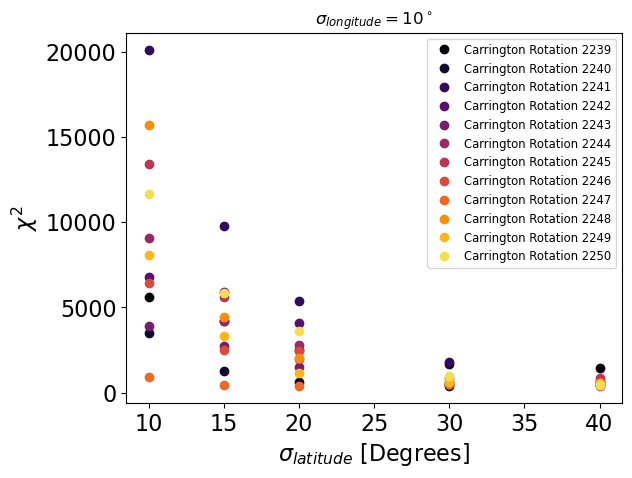

In [10]:
# Define a colormap
cmap = plt.get_cmap('inferno') 

# Plot each sublist with a different color
for i in range(len(cr_list)):
    colour = cmap(i / len(cr_list))  # Use the colormap to get a color
    plt.plot(lat_dev_list, chi_sq_set[i], color=colour, label=f'Carrington Rotation {cr_list[i]}', marker = 'o', lw = 0)

# Add labels and legend
plt.xlabel(f'$\sigma_{{latitude}}$ [Degrees]')
plt.ylabel(f'$\chi^2$')
plt.title(f'$\sigma_{{longitude}} = {long_dev}^\circ$' )
plt.legend(fontsize = 'small')

# Show the plot
plt.show()


In [90]:
cr = 2247
ensemble_size = 100
lat_dev_list = [10,15,20,25,30,35,40]
long_dev_list = np.linspace(1,20,7)
lat_lon_chi_arr = np.ones((len(lat_dev_list), len(long_dev_list)))
rng = np.random.default_rng()
                      
for i in range(len(lat_dev_list)):

    lat = lat_dev_list[i] # Set latitude variance to query
    ensemble_members = read_ens_cdf_var(cr=cr, var_dev=lat, no_members=ensemble_size) # Read in ensemble set for specified latitude variance

    for j in range(len(long_dev_list)): 

        no_members = 100
        long_pert_var = long_dev_list[j] # Degrees
        carrington_rotation = 27.2753 * u.day
        
        lp_ensemble_members = [] # Initialise list of lognitudinally perturbed (lp) ensemble members

        for df in ensemble_members:

            long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
            long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
            shifted_df = perturb_longitude(shift_amount=long_pert_dt*u.day, ensemble_member=(df.set_index('datetime')))
            lp_ensemble_members.append(shifted_df)

        ranked_forecasts = gen_ranked_ensemble(lp_ensemble_members, omni_1hour)
        # Calculate chi_sq as metric for rank histogram flatness
        lat_lon_chi_arr[i,j] = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=ranked_forecasts)



                         r  lon         vsw  bpol
2021-08-01 02:20:15  219.0  0.0  333.384021   NaN
2021-08-01 02:55:02  219.0  0.0  339.738849   NaN
2021-08-01 03:29:49  219.0  0.0  348.624650   NaN
2021-08-01 04:04:36  219.0  0.0  359.775745   NaN
2021-08-01 04:39:24  219.0  0.0  372.157837   NaN
                         r  lon         vsw  bpol
2021-08-01 02:40:52  217.5  0.0  326.698761   NaN
2021-08-01 03:15:39  219.0  0.0  329.256077   NaN
2021-08-01 03:50:26  219.0  0.0  333.384021   NaN
2021-08-01 04:25:13  219.0  0.0  339.738849   NaN
2021-08-01 05:00:00  219.0  0.0  348.624650   NaN
                         r           lon         vsw  bpol
2021-08-01 02:40:10  217.5  3.182856e-17  327.758364   NaN
2021-08-01 03:14:57  217.5  4.083039e-17  327.006342   NaN
2021-08-01 03:49:44  217.5  4.954202e-17  326.298190   NaN
2021-08-01 04:24:31  217.5  4.054003e-17  325.662526   NaN
2021-08-01 04:59:18  217.5  3.153804e-17  325.146649   NaN
                         r           lon      

In [18]:
plt.figure(dpi=100)
gs = grd.GridSpec(2, 2, height_ratios=[10,1], width_ratios=[20,10], wspace=1)

ax = plt.subplot(gs[0])
im = ax.imshow(lat_lon_chi_arr, origin = 'lower', cmap = 'inferno_r')

ax.set_ylabel(f'$\sigma_{{latitude}}$ [Deg]')
ax.set_xlabel(f'$\sigma_{{longitude}}$ [Deg]')

ax.set_yticks(np.arange(len(lat_dev_list)))
ax.set_xticks(np.arange(len(long_dev_list))[1::2])

ax.set_yticklabels([str(x) for x in lat_dev_list])
ax.set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::2], rotation = 0)


# # Colour bar on it's own axis
colorAx = plt.subplot(gs[2])
cb = plt.colorbar(im, cax = colorAx, aspect = 50, orientation = 'horizontal')
cb.set_label(f'$\chi^2$')

# plt.colorbar()
plt.tight_layout()
plt.show()

NameError: name 'lat_lon_chi_arr' is not defined

In [102]:
def calculate_chi_range_for_cr(cr, ensemble_size, lat_dev, long_dev_list):

    carrington_rotation = 27.2753 * u.day
    ensemble_members = read_ens_cdf_var(cr=cr, var_dev=lat_dev, no_members=ensemble_size) # Read in ensemble set for specified latitude variance
    lon_chi_arr = np.ones(len(long_dev_list))  

    for j in range(len(long_dev_list)): 
        
        long_pert_var = long_dev_list[j] # Degrees
        lp_ensemble_members = [] # Initialise list of lognitudinally perturbed (lp) ensemble members
        print(long_pert_var)
        
        for df in ensemble_members:

            long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
            long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day

            shifted_df = perturb_longitude(shift_amount=long_pert_dt*u.day, ensemble_member=df.copy().set_index('datetime')).copy()
            lp_ensemble_members.append(shifted_df)
            
        print(shifted_df.head())
        print(lp_ensemble_members[0].head())
        ranked_forecasts = gen_ranked_ensemble(lp_ensemble_members, omni_1hour)
        # Calculate chi_sq as metric for rank histogram flatness
        lon_chi_arr[j] = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=ranked_forecasts)

    return lon_chi_arr

In [12]:
def calculate_chi_per_cr(cr, ensemble_size, lat_dev, long_dev):

    carrington_rotation = 27.2753 * u.day
    ensemble_members = read_ens_cdf_var(cr=cr, var_dev=lat_dev, no_members=ensemble_size) # Read in ensemble set for specified latitude variance  
    lp_ensemble_members = [] # Initialise list of lognitudinally perturbed (lp) ensemble members
    for df in ensemble_members:

        long_pert = rng.normal(loc = 0, scale = long_dev, size = 1)
        long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day

        shifted_df = perturb_longitude(shift_amount=long_pert_dt*u.day, ensemble_member=df.copy().set_index('datetime'))
        lp_ensemble_members.append(shifted_df)

    return calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=ranked_forecasts)

In [124]:

#cr_list = np.arange(2239,2251,1)
cr_list = [2239,2240]
lat_dev_list = [15,20]
long_dev_list = [2,8]

ensemble_size = 100

lat_lon_chi_arr = np.ones((len(cr_list), len(lat_dev_list), len(long_dev_list)))
rng = np.random.default_rng()

for k in range(len(cr_list)):
    lat_lon_chi_arr[k] = cr_list[k]

    for i in range(len(lat_dev_list)):
        lat = lat_dev_list[i]
        print(lat)
        
        for j in range(len(long_dev_list)):
            long = long_dev_list[j]
            print(long)
            lat_lon_chi_arr[k,i,j] = calculate_chi_per_cr(cr_list[k], ensemble_size, lat, long)


15
2
8
20
2
8
15
2
8
20
2
8


In [14]:
rng = np.random.default_rng()
ensemble_size = 500
lat_dev_list = [5,10,15,20,25,35,40]
long_dev_list = np.linspace(1,20,7)
cr_list = np.arange(2239,2247,1)
lat_lon_chi_arr = np.ones((len(cr_list), len(lat_dev_list), len(long_dev_list)))

for k in range(len(cr_list)):
    lat_lon_chi_arr[k] = cr_list[k]            
    for i in range(len(lat_dev_list)):

        lat = lat_dev_list[i] # Set latitude variance to query
        ensemble_members = read_ens_cdf_var(cr=cr_list[k], var_dev=lat, no_members=ensemble_size) # Read in ensemble set for specified latitude variance

        for j in range(len(long_dev_list)): 

            long_pert_var = long_dev_list[j] # Degrees
            carrington_rotation = 27.2753 * u.day
            
            lp_ensemble_members = [] # Initialise list of lognitudinally perturbed (lp) ensemble members

            for df in ensemble_members:

                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
                shifted_df = perturb_longitude(shift_amount=long_pert_dt*u.day, ensemble_member=(df.set_index('datetime')))
                lp_ensemble_members.append(shifted_df)

            ranked_forecasts = gen_ranked_ensemble(lp_ensemble_members, omni_1hour)
            # Calculate chi_sq as metric for rank histogram flatness
            lat_lon_chi_arr[k,i,j] = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=ranked_forecasts)


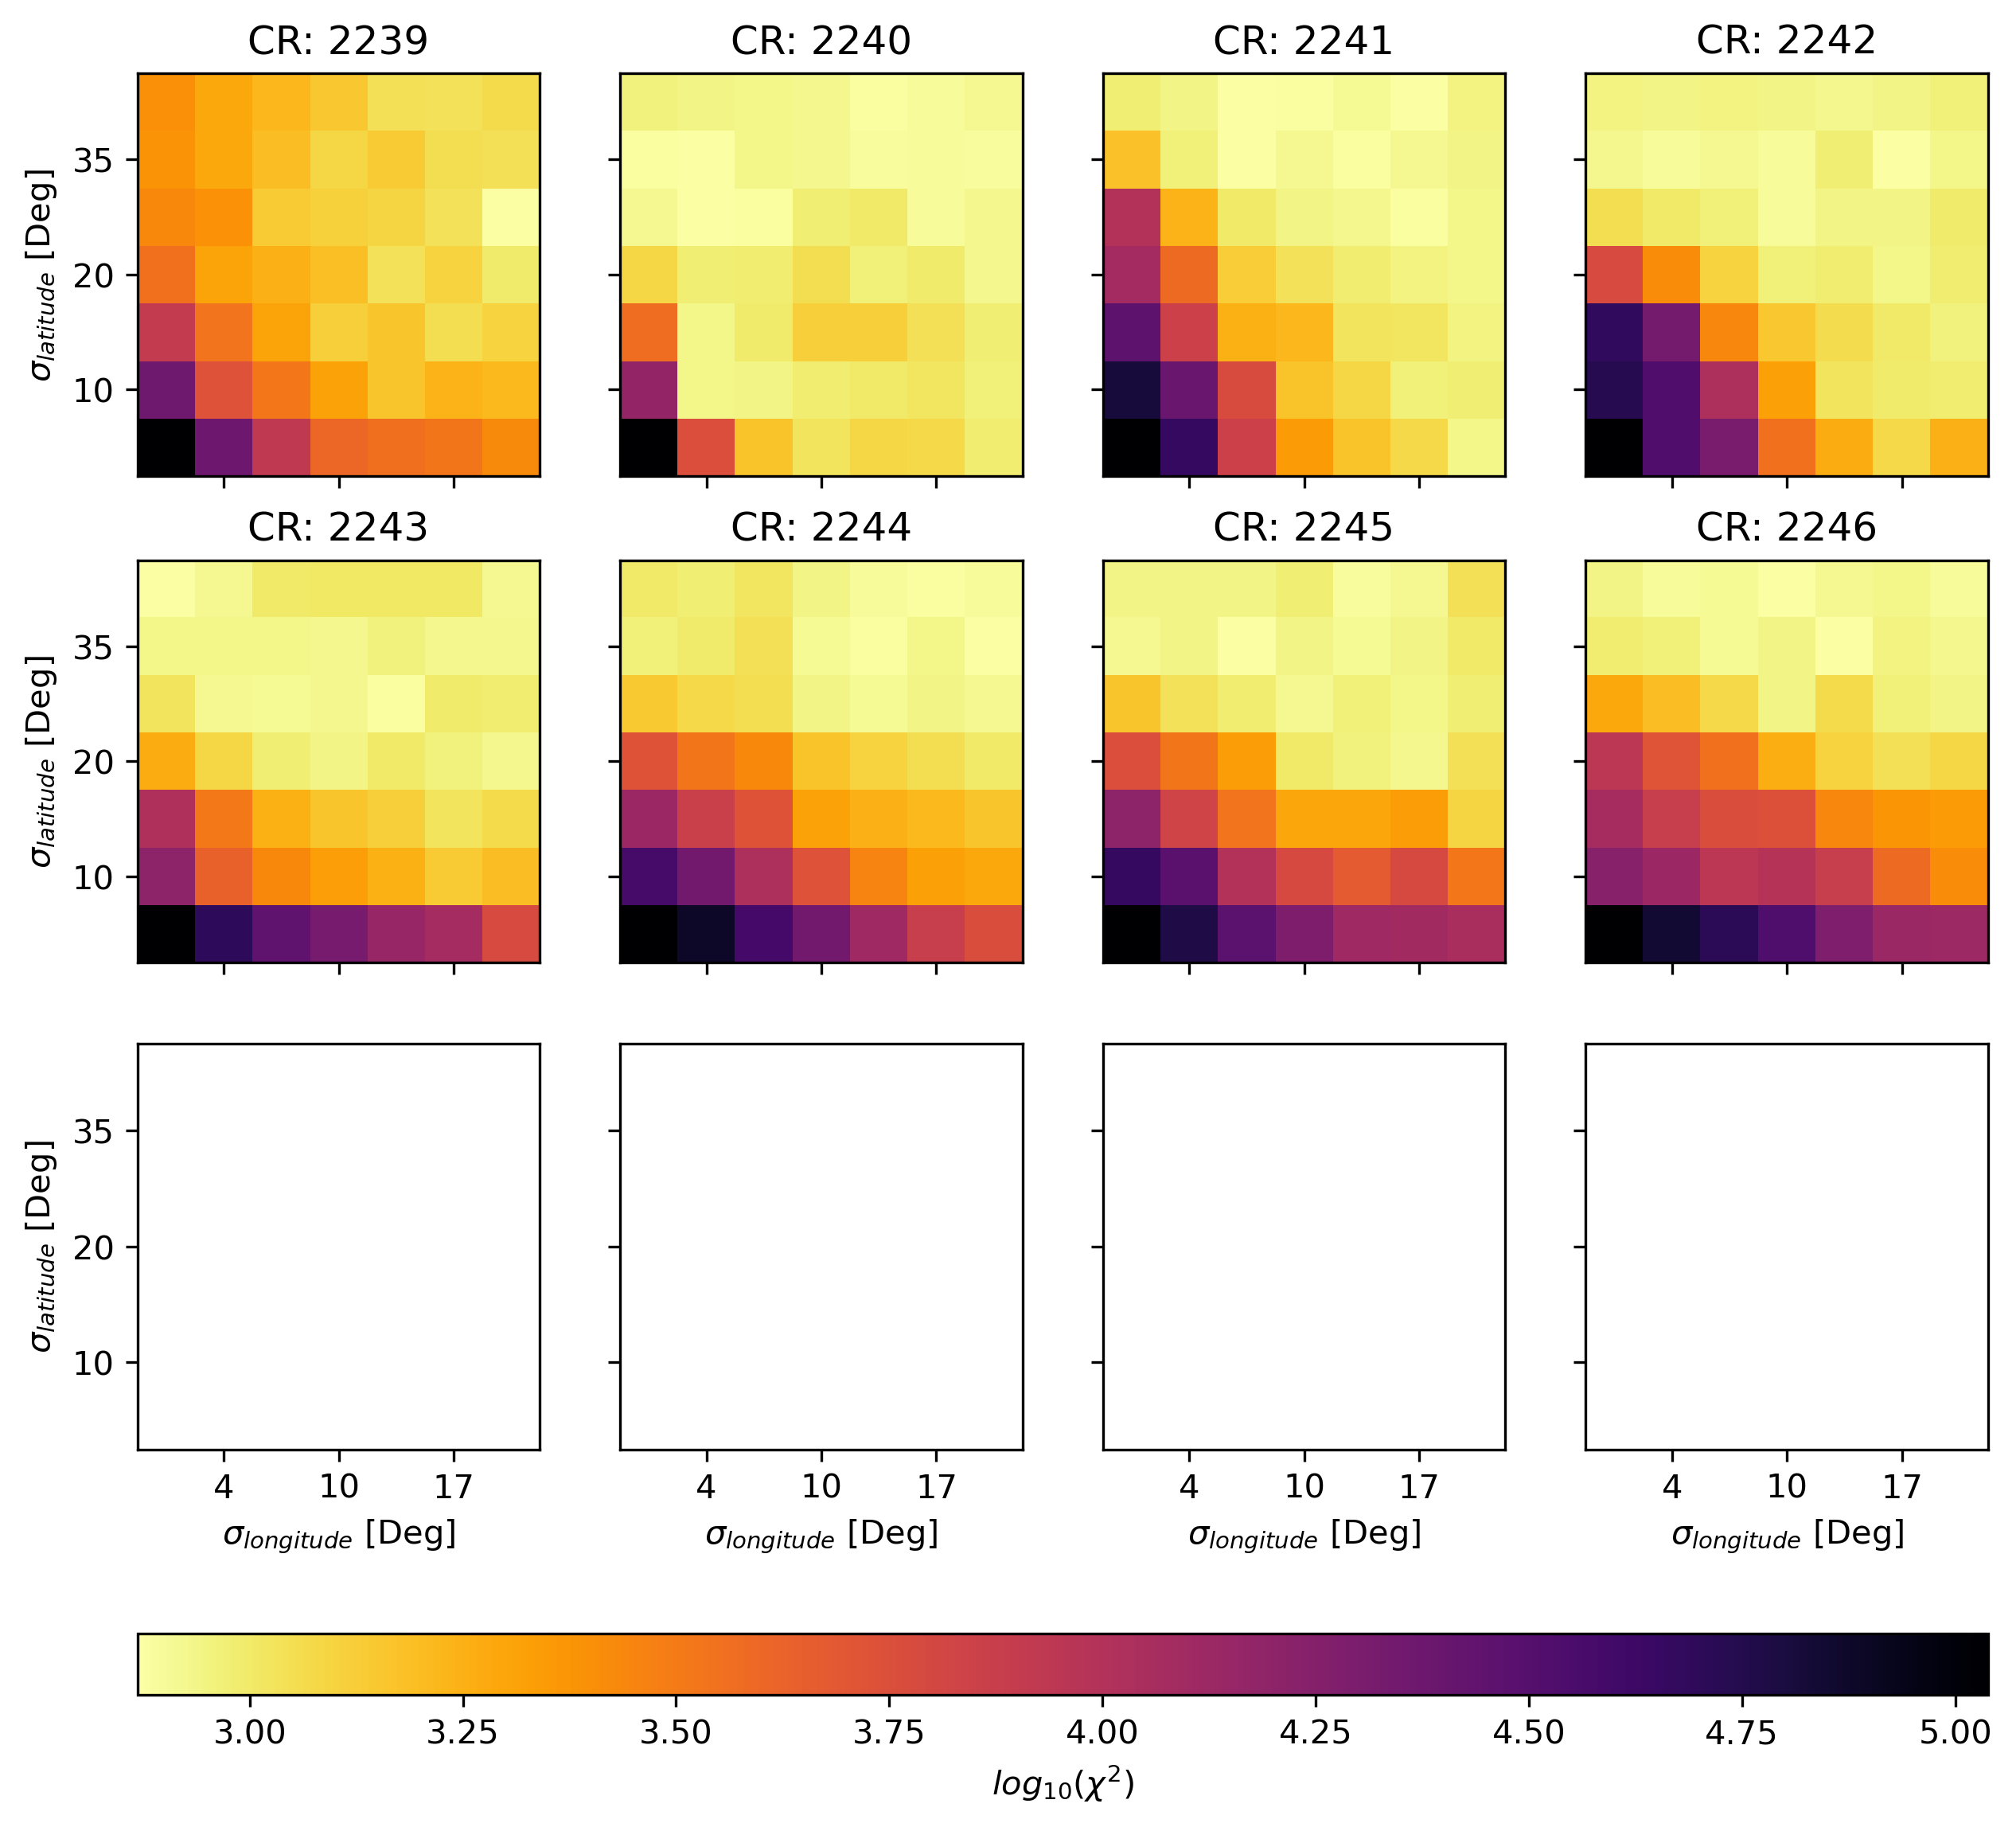

In [15]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,10), dpi = 300, sharex=True, sharey=True)

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Plot each imshow plot
for i in range(len(cr_list)):
    im = axes[i].imshow(np.log10(lat_lon_chi_arr[i]), cmap='inferno_r', origin = 'lower') 

    axes[i].set_title(f'CR: {cr_list[i]}')
    
    # axes[i].set_yticks(np.arange(len(lat_dev_list))[1::2])
    # axes[i].set_xticks(np.arange(len(long_dev_list))[1::2])

    # axes[i].set_ylabel(f'$\sigma_{{latitude}}$ [Deg]')
    # axes[i].set_xlabel(f'$\sigma_{{longitude}}$ [Deg]')

    # axes[i].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::2])
    # axes[i].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::2], rotation = 0)

outer_y_index = np.arange(0,9,4)
for y in outer_y_index:
    axes[y].set_yticks(np.arange(len(lat_dev_list))[1::2])
    axes[y].set_ylabel(f'$\sigma_{{latitude}}$ [Deg]')
    axes[y].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::2])

outer_x_index = np.arange(8,12,1)
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::2])
    axes[x].set_xlabel(f'$\sigma_{{longitude}}$ [Deg]')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::2], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'$log_{{10}}(\chi^2)$')

#plt.tight_layout()
plt.show()

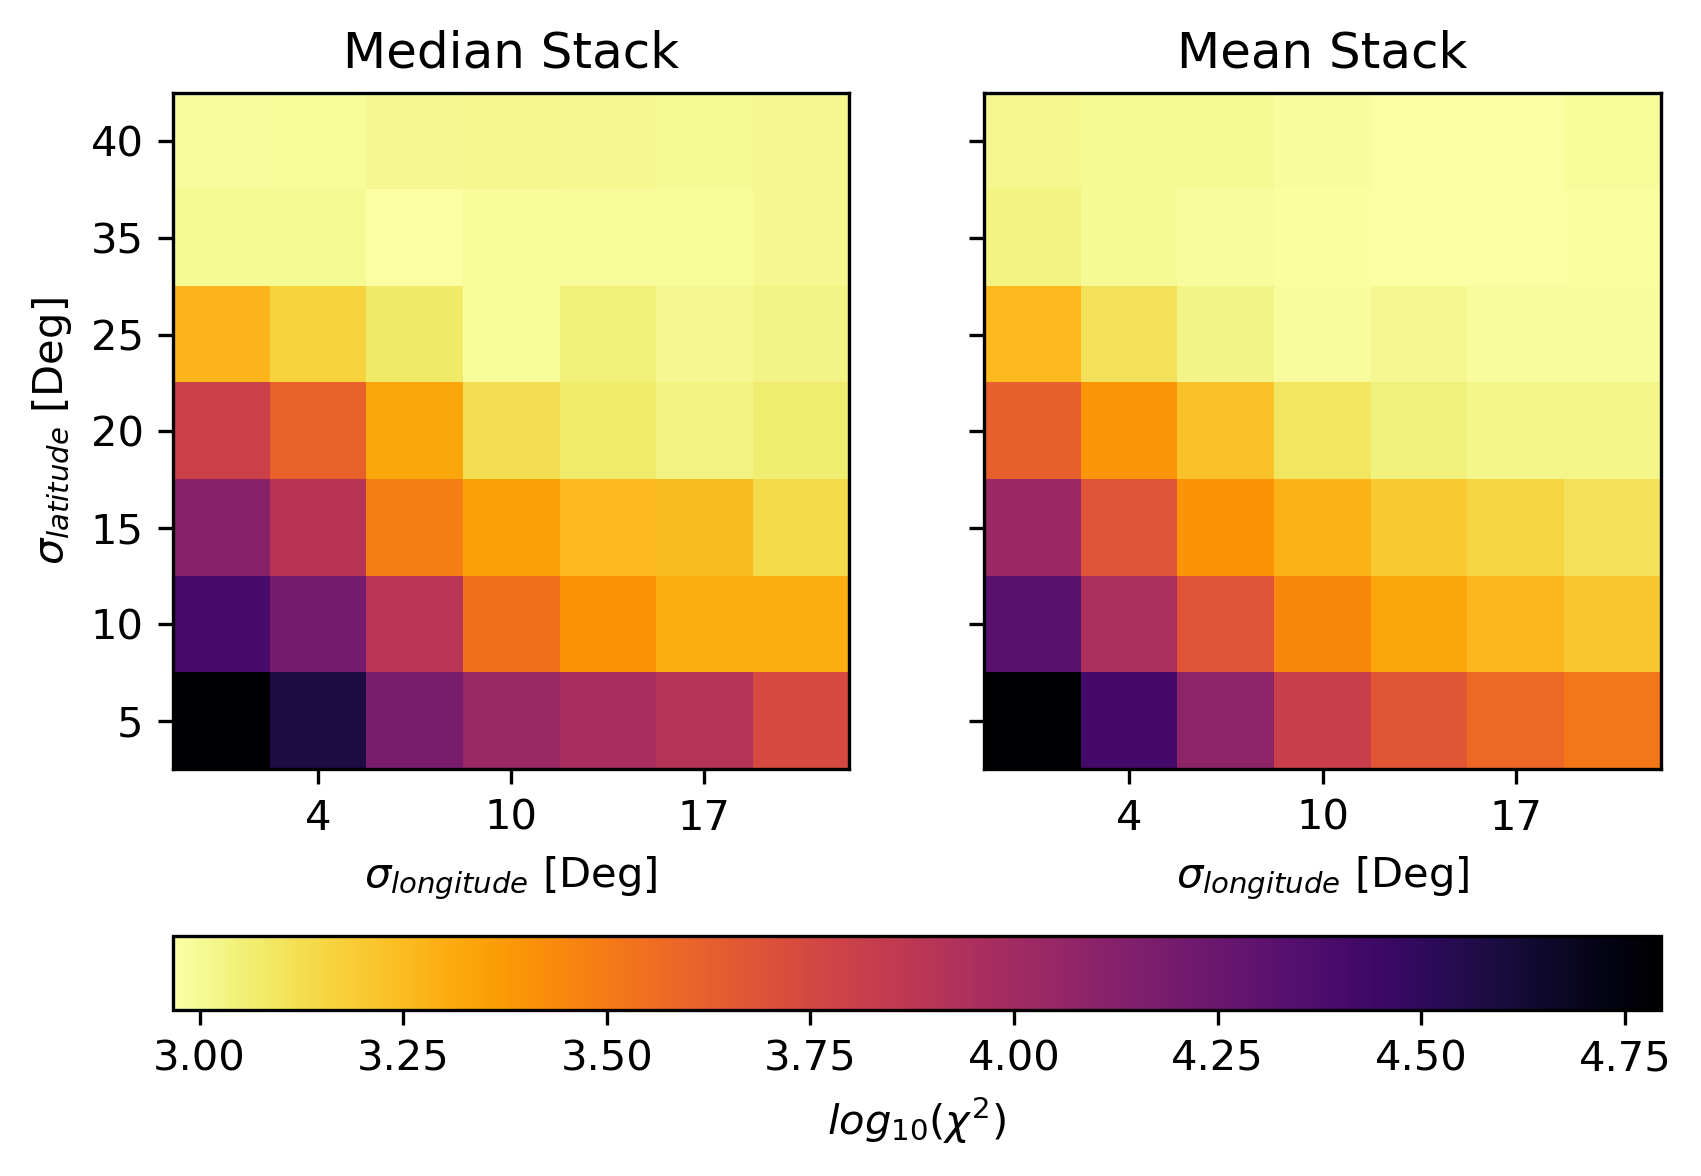

In [16]:


fig, ax = plt.subplots(ncols = 2, nrows = 1, dpi = 300, sharey=True)

im1 = ax[0].imshow(np.median(np.log10(lat_lon_chi_arr), axis = 0), origin = 'lower', cmap = 'inferno_r')
im2 = ax[1].imshow(np.mean(np.log10(lat_lon_chi_arr), axis = 0), origin = 'lower', cmap = 'inferno_r')

ax[0].set_title('Median Stack')
ax[0].set_ylabel(f'$\sigma_{{latitude}}$ [Deg]')
ax[0].set_xlabel(f'$\sigma_{{longitude}}$ [Deg]')

ax[0].set_yticks(np.arange(len(lat_dev_list)))
ax[0].set_xticks(np.arange(len(long_dev_list))[1::2])

ax[0].set_yticklabels([str(x) for x in lat_dev_list])
ax[0].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::2], rotation = 0)

ax[1].set_title('Mean Stack')
ax[1].set_xlabel(f'$\sigma_{{longitude}}$ [Deg]')
ax[1].set_xticks(np.arange(len(long_dev_list))[1::2])
ax[1].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::2], rotation = 0)

# # Colour bar
cbar = fig.colorbar(im1, ax=ax, orientation = 'horizontal') 
cbar.set_label(f'$log_{{10}}(\chi^2)$')

plt.show()